In [1]:
import numpy as np
import cv2, os, time
import matplotlib.pyplot as plt
from tqdm import tqdm

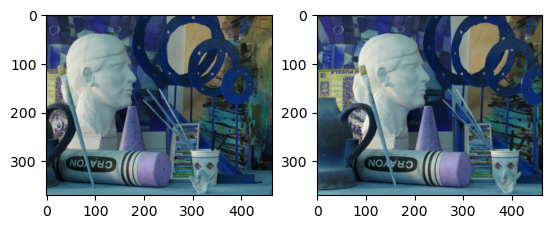

In [2]:
root = 'stereo_ds/'

folder_name = os.listdir(root)[0]

left_img_path = 'stereo_ds/{0}/view5.png'.format(folder_name)
right_img_path = 'stereo_ds/{0}/view1.png'.format(folder_name)

l_img = cv2.imread(left_img_path) 
r_img = cv2.imread(right_img_path) 

fig,ax = plt.subplots(1,2)
ax[0].imshow(l_img)
ax[1].imshow(r_img)
plt.show()

In [3]:
l_img.shape

(370, 463, 3)

In [77]:
# https://vision.middlebury.edu/stereo/data/scenes2005/#description
focal_length = 3740 # in pixels
camera_baseline = 160/1000 # in milli meters
scale = 3
dmin = 200

def project_disparity_to_3d(disparity):

    points = []

    f = focal_length
    B = camera_baseline

    height, width = disparity.shape[:2]

    for y in range(height): # 0 - height is the y axis index
        for x in range(width): # 0 - width is the x axis index

            # if we have a valid non-zero disparity
            if (disparity[y,x] > 0):
                
                Z = (f * B) / (disparity[y,x] + dmin)

                X = ((x - width/2) * Z) / f
                Y = ((y - height/2) * Z) / f

                points.append([X,Y,Z])

    return points

In [21]:
def NaiveStereoVision(l_img, r_img, k_size, max_offset):
    
    def mse(l_win, r_win):
        return np.sum((l_window.flatten()-r_window.flatten())**2)
    
    def inv_corr_coeff(l_win, r_win):
        return 1/(np.corrcoeff(l_win.flatten(),r_win.flatten())[0,-1] + 2) # +2 against zero division
    
    
    
    img_h,img_w,color_depth = l_img.shape
    corres_dict = {}

    half_k_size = k_size // 2

    for h in tqdm(range(half_k_size, img_h - half_k_size)): # img_h - w_size
        for w in (range(half_k_size, img_w -  half_k_size)):
            corr_coeff_list = []   
            l_window = l_img[h - half_k_size:h+half_k_size,w - half_k_size:w+half_k_size,:]
            for w_check in (range(w,w + max_offset)):
                r_window = r_img[h - half_k_size:h+half_k_size,w_check - half_k_size:w_check+half_k_size,:]
                if r_window.shape==l_window.shape:
                    corr_coeff = mse(l_window, r_window) # mse, inv_corr_coeff
                    corr_coeff_list.append(corr_coeff)
            corres_dict[(h,w)] = w + np.argmin(corr_coeff_list) 

    disp_img = np.zeros((img_h,img_w))
    for h,w in corres_dict:
        disp_img[h,w] = np.abs(corres_dict[(h,w)] - w) * scale

    return disp_img

In [22]:
start_ = time.time()
disp_img = NaiveStereoVision(l_img, r_img, 7, 100)
end_ = time.time()

print('Ellapsed Time', end_-start_)

100%|██████████| 364/364 [02:14<00:00,  2.70it/s]


Ellapsed Time 135.00437116622925


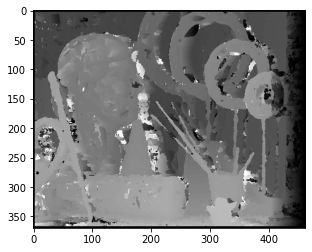

In [34]:
plt.imshow(disp_img,cmap='gray')
plt.savefig('disps/Naive_{}.png'.format(folder_name))
plt.show()

In [78]:
np.savetxt('xyz/Naive_{0}_{1}_seconds.xyz'.format(folder_name, end_ - start_), project_disparity_to_3d(disp_img), delimiter = ' ')

# Further Idea

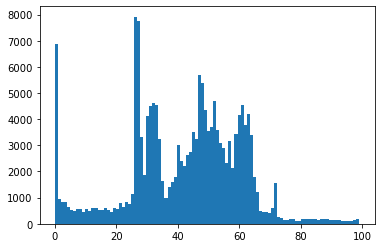

In [32]:
# I believe this is natural To apply Gaussian Mixture Models to
# calculate the likelood of the presence of the the given disparity
# which then could be used for disparity normalization by removing
# anomalic disparity values

# My hypothesis is for the horizontal shift, disparity should be between
# probabilistic range. This could be done as a future work with various anomaly
# detection algorithms

plt.hist(disp_img.flatten(), bins = 100)
plt.show()

# Dynamic Programming

### Get Row, Forward match, Backtrack repeat

In [13]:
def SSD(pixelL,pixelR,sigma=2):
    ssd = np.mean((pixelL-pixelR)**2/(sigma**2))
    return ssd

In [14]:
def dynamic_matching_forward(rowL, rowR):
    N = rowL.shape[0]
    M = rowR.shape[0]
    cost_matrix = np.ones((N,M))
    match_matrix = np.zeros((N,M))

    occlusion_cost = 1

    cost_matrix[0][0] = SSD(rowL[0], rowR[0])

    for i in range(1, N):
        cost_matrix[i][0] = i*occlusion_cost
    for j in range(1, M):
        cost_matrix[0][j] = j*occlusion_cost

    for i in range(1, N):
        for j in range(1, M):
            min_match = cost_matrix[i - 1][j -1] + SSD(rowL[i], rowR[j])
            min_l = cost_matrix[i - 1][j] + occlusion_cost
            min_r = cost_matrix[i][j - 1] + occlusion_cost

            cost_matrix[i][j] = np.min([min_match, min_l, min_r])
            match_matrix[i][j] = np.argmin([min_match, min_l, min_r]) + 1
    return (match_matrix, cost_matrix)

In [15]:
def dynyamic_matching_backtrack(match_matrix):
    rowL = rowR = match_matrix.shape[0]-1
    disp_vec = np.zeros((match_matrix.shape[0],1))
    disp_acc = 0
    
    while(rowL!=0 and rowR!=0):
        z = match_matrix[rowL][rowR]
        if(z==1):
            rowL -= 1 
            rowR -= 1
            disp_vec[rowL] = abs(rowR-rowL)
        elif(z==2):
            rowL -= 1 
            disp_acc += 1
            disp_vec[rowL] = 0
        elif(z==3):
            rowR -= 1
            disp_acc -= 1

    return disp_vec

In [16]:
def dynamic_disparity(imgL_bw, imgR_bw):

    disp_map = np.zeros(imgR_bw.shape)

    for row in tqdm(range(imgL_bw.shape[0])):
        row_match_matrix, row_cost_matrix = dynamic_matching_forward(imgL_bw[row], imgR_bw[row])

        disp_row= dynyamic_matching_backtrack(row_match_matrix)
        
        disp_map[row] = disp_row

    return disp_map

In [ ]:
start = time.time()
disp_img_dyn = dynamic_disparity(l_img, r_img)
end = time.time()

print('Ellapsed Time', end-start)

  6%|▌         | 21/370 [02:09<35:46,  6.15s/it]

In [79]:
np.savetxt('xyz/DP_{0}_{1}_seconds.xyz'.format(folder_name, end - start), project_disparity_to_3d(disp_img_dyn[:,:,0]), delimiter = ' ')

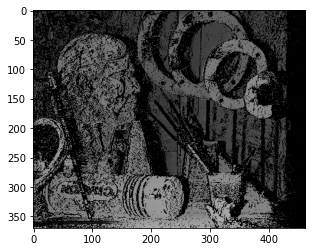

In [35]:
plt.imshow(disp_img_dyn[:,:,0],cmap='gray')
plt.savefig('disps/DP_{}.png'.format(folder_name))
plt.show()

# Time Comparison

In [41]:
import pandas as pd

In [45]:
Method_Data_Sec = [file_name.split('_')[:3] for file_name in os.listdir('xyz') if '.xyz' in file_name]

In [49]:
df_time = pd.DataFrame(Method_Data_Sec, columns = ['Method','Set','Seconds'])
df_time['Seconds'] = df_time['Seconds'].to_numpy().astype(float)

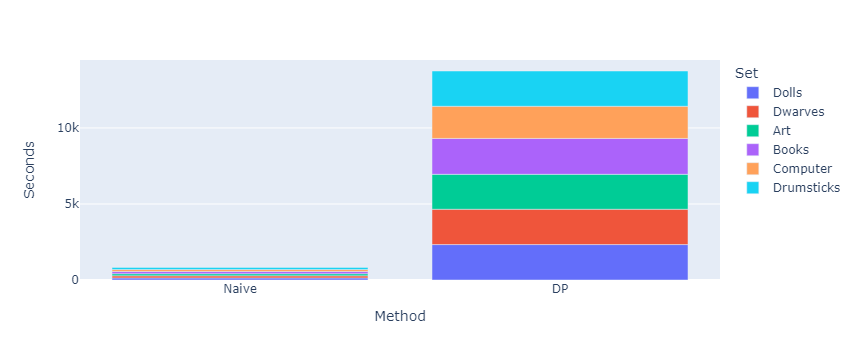

In [54]:
import plotly.express as px
fig = px.bar(df_time, x='Method', y='Seconds', color = 'Set')
fig.show()

In [60]:
print('Average time for Naive:',df_time[df_time['Method']=='Naive']['Seconds'].mean(),'Seconds')
print('Average time for DP:',df_time[df_time['Method']=='DP']['Seconds'].mean(),'Seconds')

Average time for Naive: 137.96238760153452 Seconds
Average time for DP: 2291.0803072055182 Seconds


	zip warning: missing end signature--probably not a zip file (did you
	zip warning: remember to use binary mode when you transferred it?)
	zip warning: (if you are trying to read a damaged archive try -F)

zip error: Zip file structure invalid (.)
